In [2]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment
import polars

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [3]:
train_data = pd.read_feather('../data/train_data.ftr')

In [4]:
train_data.shape

(5531451, 191)

In [5]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [6]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

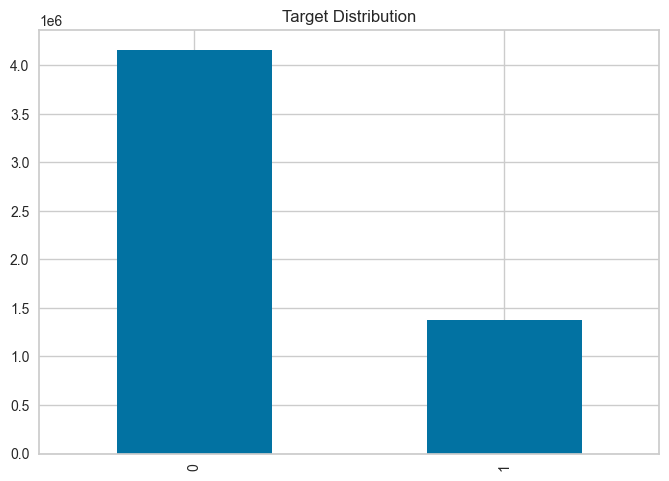

In [7]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [8]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [9]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]



In [10]:
# pick random 5000 customer_ID from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 5000, replace=False)

In [11]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]

0    0.763853
1    0.236147
Name: target, dtype: float64


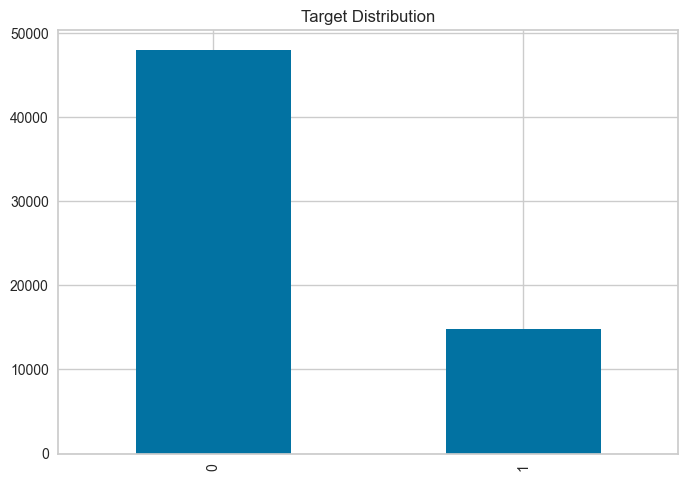

In [12]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

<AxesSubplot: title={'center': 'Distribution of number of records per customer_ID'}, ylabel='Frequency'>

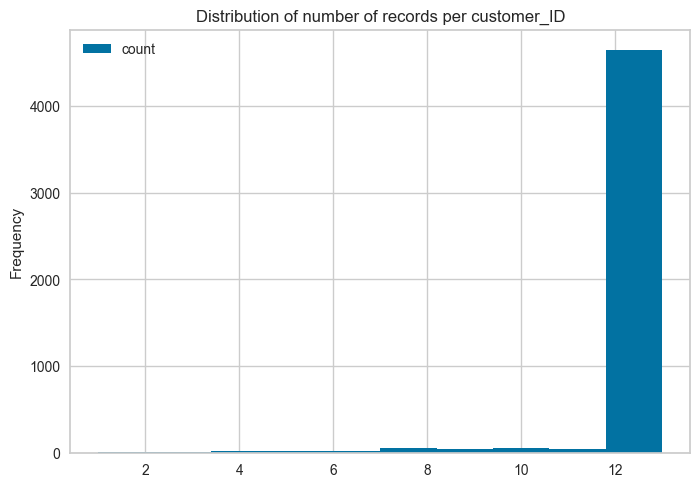

In [13]:
# calculate the number of records per customer_ID
records_per_cust = train_rndm_sample.groupby(
    'customer_ID').size().reset_index().rename(columns={
        0: 'count'
    }).sort_values(by='count', ascending=False)

# plot the distribution of number of records per customer_ID
records_per_cust.plot(
    kind='hist', title='Distribution of number of records per customer_ID')


In [14]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fold_strategy='timeseries', fix_imbalance=True, experiment_name='timeseries_fold', data_split_shuffle = False,data_split_stratify = False)

In [16]:
best = s.compare_models()

In [17]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

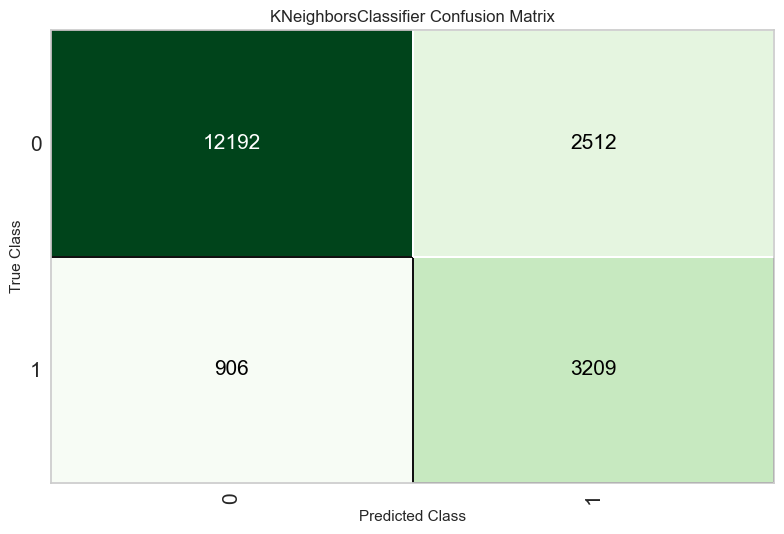

In [18]:
s.plot_model(best, plot = 'confusion_matrix')

In [19]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8046,0.8456,0.7686,0.5662,0.6518,0.5202,0.5322,0.671
dt,Decision Tree Classifier,0.6041,0.4995,0.2923,0.2361,0.1975,-0.0014,0.0008,0.185
nb,Naive Bayes,0.6189,0.5519,0.3348,0.5576,0.1778,0.0509,0.1090,0.131
qda,Quadratic Discriminant Analysis,0.6263,0.5529,0.3259,0.5560,0.1743,0.0503,0.1107,0.162
svm,SVM - Linear Kernel,0.7791,0.0000,0.1089,0.6585,0.1719,0.1306,0.1926,0.155
et,Extra Trees Classifier,0.7799,0.8982,0.1084,0.8744,0.1633,0.1279,0.2201,0.139
catboost,CatBoost Classifier,0.7201,0.7278,0.1650,0.1973,0.1348,0.0717,0.0915,0.234
lr,Logistic Regression,0.7757,0.9036,0.0830,0.8671,0.1279,0.0999,0.1804,0.272
lightgbm,Light Gradient Boosting Machine,0.6174,0.5304,0.2905,0.2055,0.1251,0.0059,0.0134,0.181
xgboost,Extreme Gradient Boosting,0.6551,0.7443,0.2102,0.4263,0.0937,0.0138,0.0401,0.137
